## Создадим датасет

### Начальная установка

Установим необходимые завсимости

In [1]:
# %pip install PySpice

In [2]:
# %conda install -c conda-forge ngspice-exe

In [3]:
# %conda install -c conda-forge ngspice

In [4]:
# %conda install -c conda-forge ngspice-lib

### Необходимый импорт

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tqdm import tqdm

In [3]:
####################################################################################################

import matplotlib.pyplot as plt
%matplotlib notebook

####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

####################################################################################################

Промоделируем работу MOSFET транзистора

In [4]:
spice_library = SpiceLibrary("C:/Users/lario/MyAnacondaProject/example/libraries")

In [5]:
for key in spice_library.models:
    print(key)

ami05nfet
ami05pfet
tsmc018nfet
tsmc018pfet
nfet
pfet
BAV21
BAV21@xyce
2n2222a
ptm32nm_nmos
ptm32nm_pmos
ptm65nm_nmos
ptm65nm_pmos


In [6]:
for key in spice_library.subcircuits:
    print(key)

QS6K1
1N5822
1N4148
d1n5919brl
irf150
LMV981


In [7]:
def mos_circuit(params=None):
#     d = {'vg': 1, 'vd': 2, 'length': 1e-6, 'width':1e-6, 'temp': 25}
    d = {'vg': 1, 'vd': 2, 'length': 5e-7, 'width':5e-7, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
#     circuit.model('NMOS-SH', 'nmos', Kp=190e-6, Vto=0.57, Lambda=0.16, Gamma=0.50, Phi=0.7)
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
#     circuit.M(1, 'VD', 'VG', 0, 0, model='NMOS-SH', l=d['length'], w=d['width'], temp=d['temp'])


#     circuit.include(spice_library['ptm65nm_nmos'])
#     circuit.M(1, 'VD', 'VG', 0, 0, model='ptm65nm_nmos', l=d['length'], w=d['width'])
    
    
    circuit.include(spice_library['tsmc018nfet'])
    circuit.MOSFET(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', l=d['length'], w=d['width'], )

#     circuit.include(spice_library['QS6K1'])
#     circuit.X(1, 'VD', 'VG', 0, 0, model='QS6K1', l=d['length'], w=d['width'], )
#     circuit.X(1, 'QS6K1', 'VD', 'VG', 0, l=d['length'], w=d['width'], )
    
#     circuit.MOSFET(1, 'VD', 'VG', circuit.gnd, circuit.gnd, model='ptm65nm_nmos')
    return circuit

print(mos_circuit())

.title MOS circuit
.include C:\Users\lario\MyAnacondaProject\example\libraries\tsmc018(3).lib
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 tsmc018nfet l=5e-07 w=5e-07



In [8]:
# dir(mos_circuit())

In [9]:
def sweep_source(first_source_name, first_source_range, second_source_name, second_source_range):
    y = []
    
    for s in second_source_range:
        circuit = mos_circuit({f'{second_source_name}':s})
        
        if second_source_name == 'temp':
            simulator = circuit.simulator(temperature=s, normal_temperature=25)
        else:
            simulator = circuit.simulator(temperature=25, normal_temperature=25)
            
        if first_source_name == 'vg':
            analysis = simulator.dc(VG=first_source_range)
        else:
            analysis = simulator.dc(VD=first_source_range)
        y.append(- np.array(analysis.branches['vd']))
        
    x = np.array(analysis.nodes[first_source_name])
    return x, y

In [10]:
def plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, func=lambda x: x):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)
    
    for i, s in enumerate(second_source_range):
        ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')
    
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


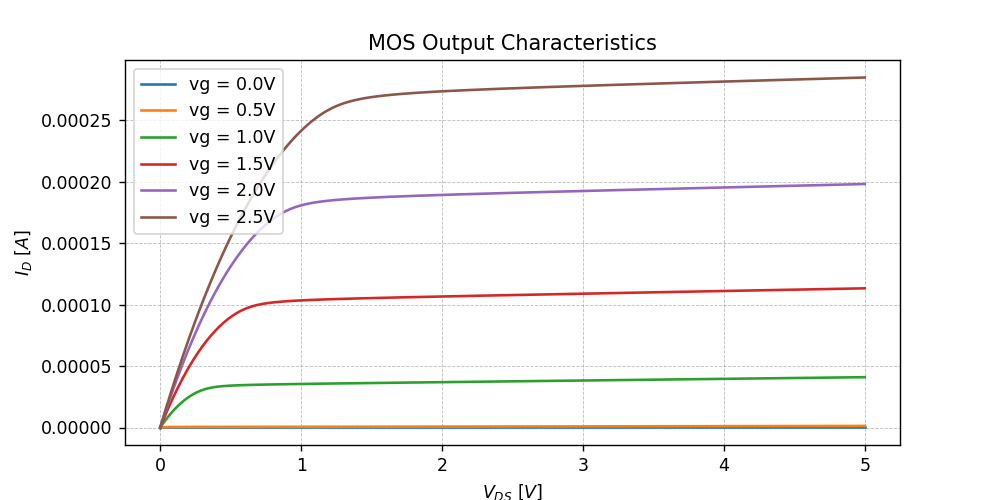

In [11]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Output Characteristics'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

<IPython.core.display.Javascript object>


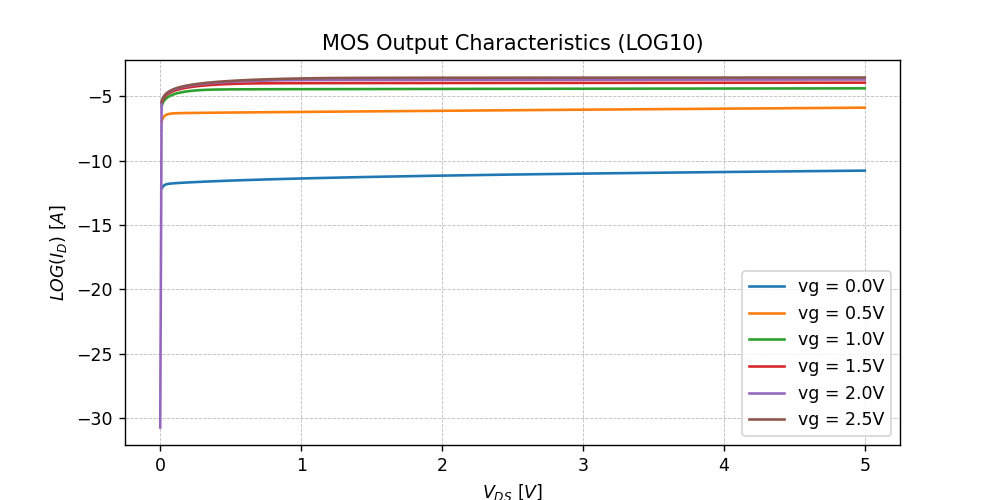

C:\Users\lario\AppData\Local\Temp\ipykernel_4340\523821518.py:8: RuntimeWarning: invalid value encountered in log10
  ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')


In [12]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$LOG(I_{D})\ [A]$'
title = 'MOS Output Characteristics (LOG10)'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, np.log10)

<IPython.core.display.Javascript object>


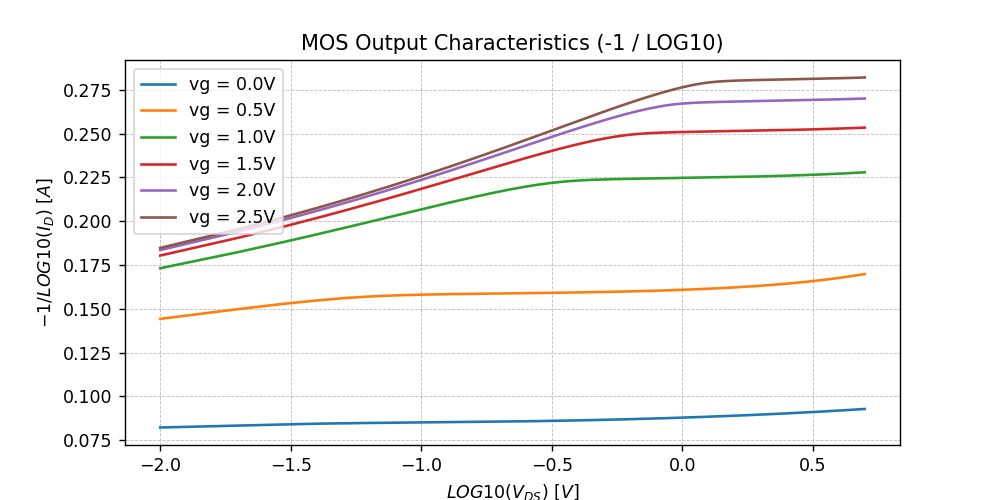

C:\Users\lario\AppData\Local\Temp\ipykernel_4340\1597664808.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(x), -1 / np.log10(y[i]), label=f'{second_source_name} = {str(s)}V')
C:\Users\lario\AppData\Local\Temp\ipykernel_4340\1597664808.py:18: RuntimeWarning: invalid value encountered in log10
  ax.plot(np.log10(x), -1 / np.log10(y[i]), label=f'{second_source_name} = {str(s)}V')


In [13]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$LOG10(V_{DS})\ [V]$'
y_label = '$-1 / LOG10(I_{D})\ [A]$'
title = 'MOS Output Characteristics (-1 / LOG10)'

fig, ax = plt.subplots(figsize=(8, 4))
    
ax.set(xlabel=x_label, ylabel=y_label, title=title)
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

for i, s in enumerate(second_source_range):
    ax.plot(np.log10(x), -1 / np.log10(y[i]), label=f'{second_source_name} = {str(s)}V')
    
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


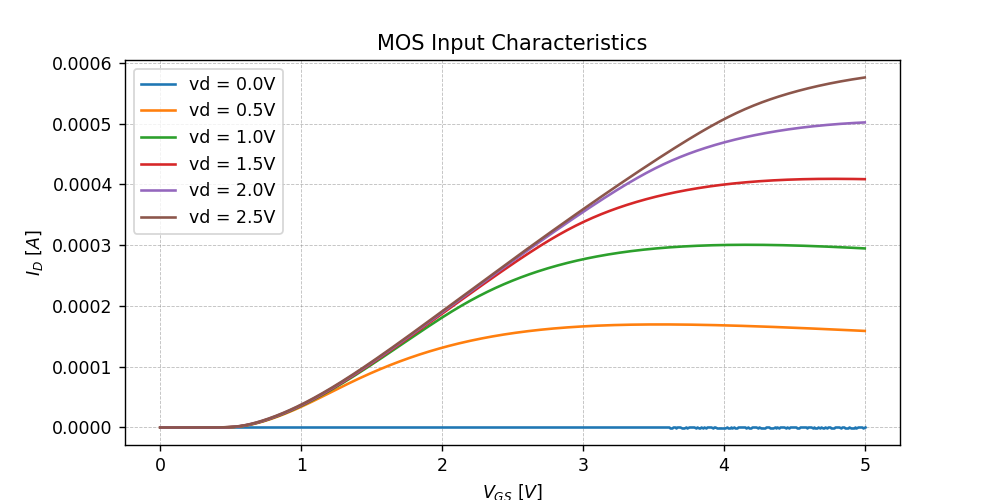

In [14]:
first_source_name = 'vg'
first_source_range = slice(0, 5, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

<IPython.core.display.Javascript object>


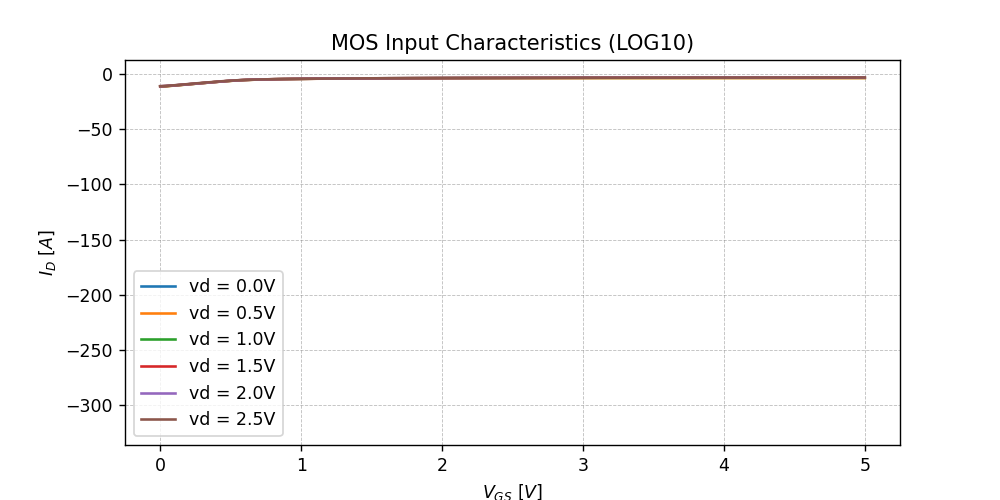

C:\Users\lario\AppData\Local\Temp\ipykernel_4340\523821518.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')
C:\Users\lario\AppData\Local\Temp\ipykernel_4340\523821518.py:8: RuntimeWarning: invalid value encountered in log10
  ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')


In [15]:
first_source_name = 'vg'
first_source_range = slice(0, 5, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'MOS Input Characteristics (LOG10)'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, np.log10)

<IPython.core.display.Javascript object>


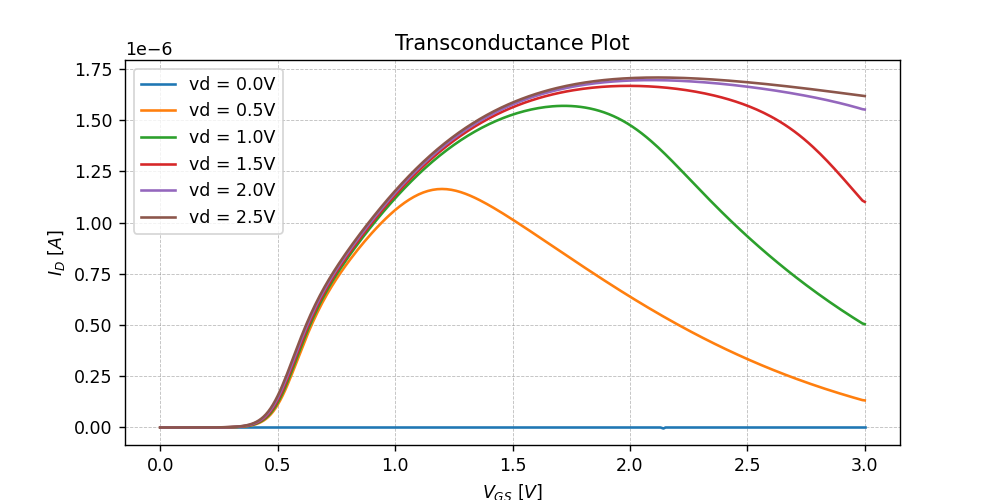

In [16]:
first_source_name = 'vg'
first_source_range = slice(0, 3, .01)
second_source_name = 'vd'
second_source_range = np.arange(0, 3, 0.5)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{GS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Transconductance Plot'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, np.gradient)

<IPython.core.display.Javascript object>


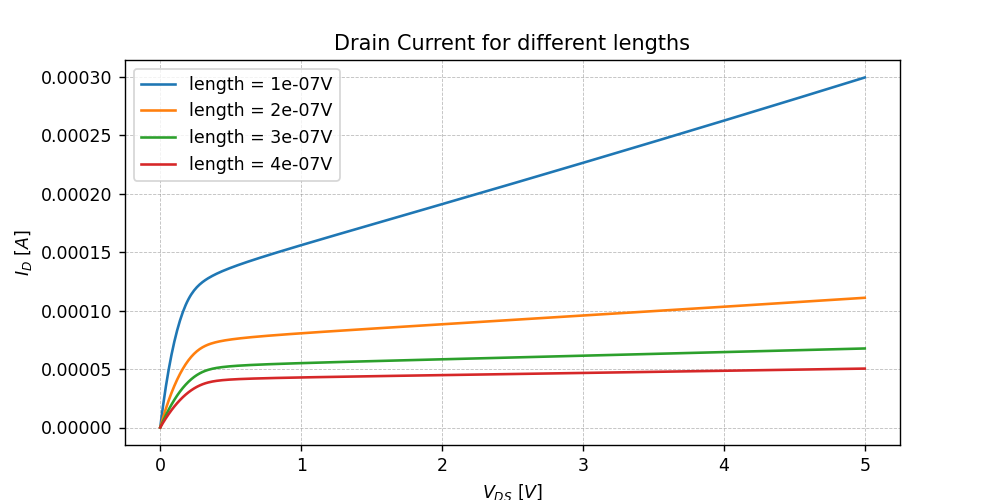

In [17]:
first_source_name = 'vd'
first_source_range = slice(0, 5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1e-7

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different lengths'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

<IPython.core.display.Javascript object>


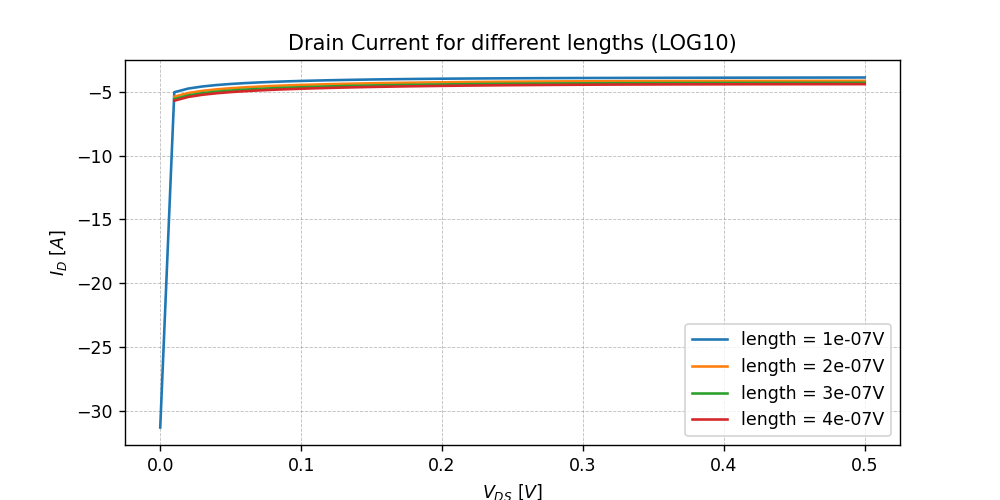

C:\Users\lario\AppData\Local\Temp\ipykernel_4340\523821518.py:8: RuntimeWarning: invalid value encountered in log10
  ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')


In [18]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'length'
second_source_range = np.arange(1, 5, 1) * 1e-7

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different lengths (LOG10)'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, np.log10)

<IPython.core.display.Javascript object>


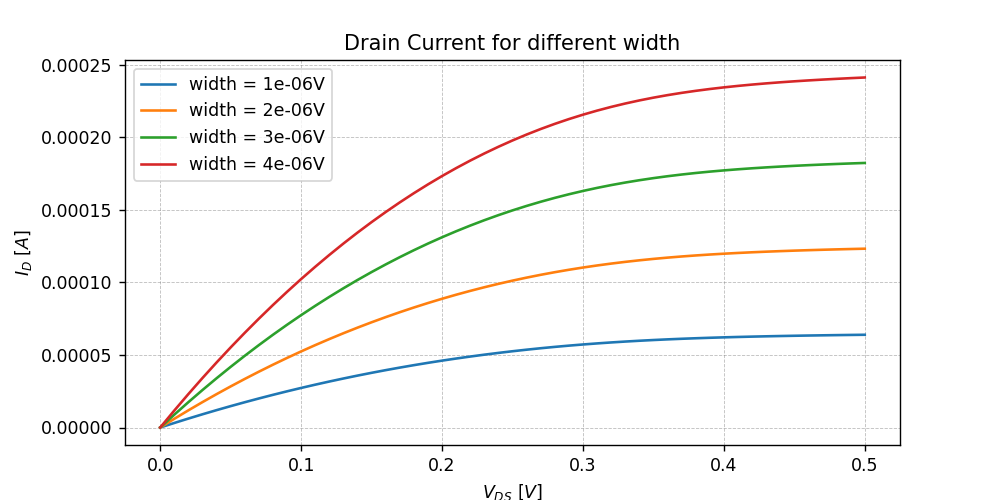

In [19]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1e-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

<IPython.core.display.Javascript object>


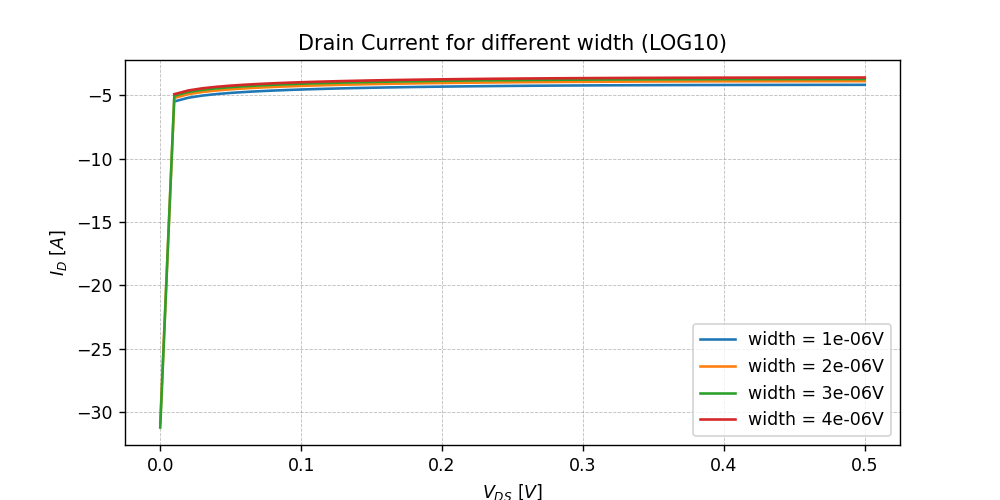

C:\Users\lario\AppData\Local\Temp\ipykernel_4340\523821518.py:8: RuntimeWarning: invalid value encountered in log10
  ax.plot(x, func(y[i]), label=f'{second_source_name} = {str(s)}V')


In [20]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'width'
second_source_range = np.arange(1, 5, 1) * 1e-6

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width (LOG10)'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range, np.log10)

<IPython.core.display.Javascript object>


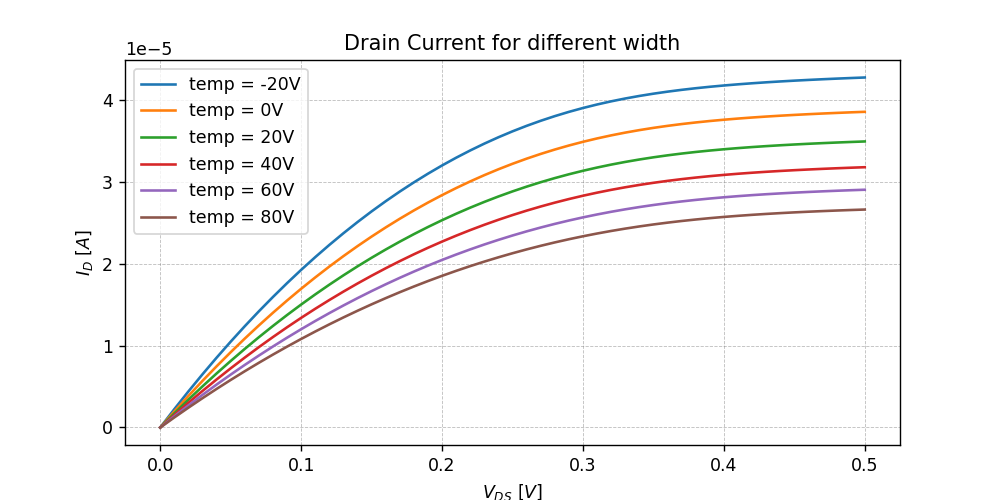

In [21]:
first_source_name = 'vd'
first_source_range = slice(0, 0.5, .01)
second_source_name = 'temp'
second_source_range = np.arange(-20, 100, 20)

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

x_label = '$V_{DS}\ [V]$'
y_label = '$I_{D}\ [A]$'
title = 'Drain Current for different width'

plot(x_label, y_label, title, first_source_name, x, y, second_source_name, second_source_range)

<IPython.core.display.Javascript object>


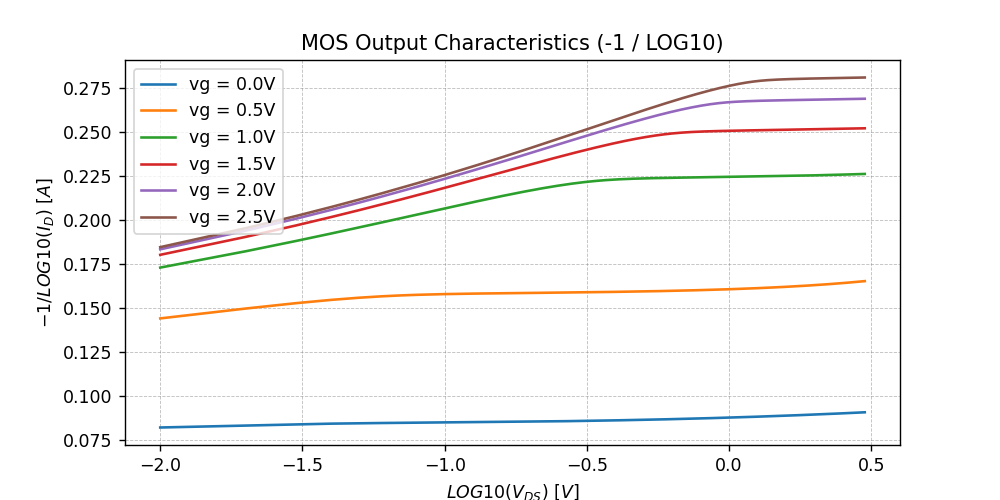

C:\Users\lario\AppData\Local\Temp\ipykernel_4340\3457756489.py:17: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(x), -1 / np.log10(y[i]), label=f'{second_source_name} = {str(s)}V')
C:\Users\lario\AppData\Local\Temp\ipykernel_4340\3457756489.py:17: RuntimeWarning: invalid value encountered in log10
  ax.plot(np.log10(x), -1 / np.log10(y[i]), label=f'{second_source_name} = {str(s)}V')


In [22]:
first_source_name = 'vd'
first_source_range = slice(0, 3, .01)
second_source_name = 'vg'
second_source_range = np.arange(0, 3, 0.5)
x_label = '$LOG10(V_{DS})\ [V]$'
y_label = '$-1 / LOG10(I_{D})\ [A]$'
title = 'MOS Output Characteristics (-1 / LOG10)'

x, y = sweep_source(first_source_name, first_source_range, second_source_name, second_source_range)

fig, ax = plt.subplots(figsize=(8, 4))
    
ax.set(xlabel=x_label, ylabel=y_label, title=title)
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

for i, s in enumerate(second_source_range):
    ax.plot(np.log10(x), -1 / np.log10(y[i]), label=f'{second_source_name} = {str(s)}V')
    
ax.legend()
plt.show()

In [23]:
def func_3d(vd_slice, vg_range):
    dataset = {'Vds': [], 'Vgs': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    Id = np.array([])
    
    for vg in vg_range:
        circuit = mos_circuit({'vg':vg, })
        simulator = circuit.simulator(temperature=25, normal_temperature=25)
        analysis = simulator.dc(VD=vd_slice)
        
        id_range = (- np.array(analysis.branches['vd']))
        len_id = len(id_range)
        
        vd_range = np.arange(vd_slice.start, vd_slice.stop + vd_slice.step, vd_slice.step)
        
        Vds = np.hstack((Vds, vd_range))
        Vgs = np.hstack((Vgs, [vg] * len_id))
        Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['Id'] = Id.tolist()
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

In [24]:
# %matplotlib notebook

<IPython.core.display.Javascript object>


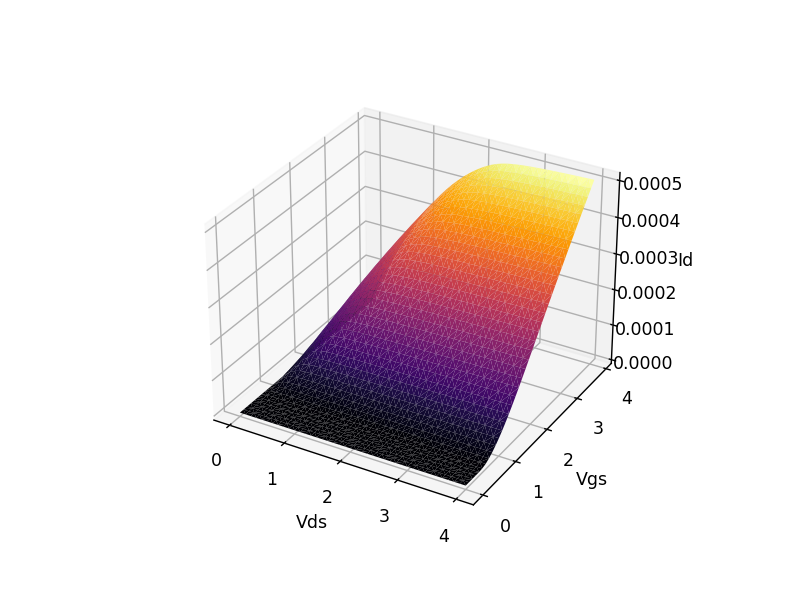

In [25]:
plot3d = func_3d(slice(0, 4, .1), np.arange(0, 4, 0.1))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

# ax.view_init(elev=45, azim=0)

ax.plot_trisurf(plot3d['Vds'].to_numpy(), plot3d['Vgs'].to_numpy(), plot3d['Id'].to_numpy(), cmap='inferno')

<IPython.core.display.Javascript object>


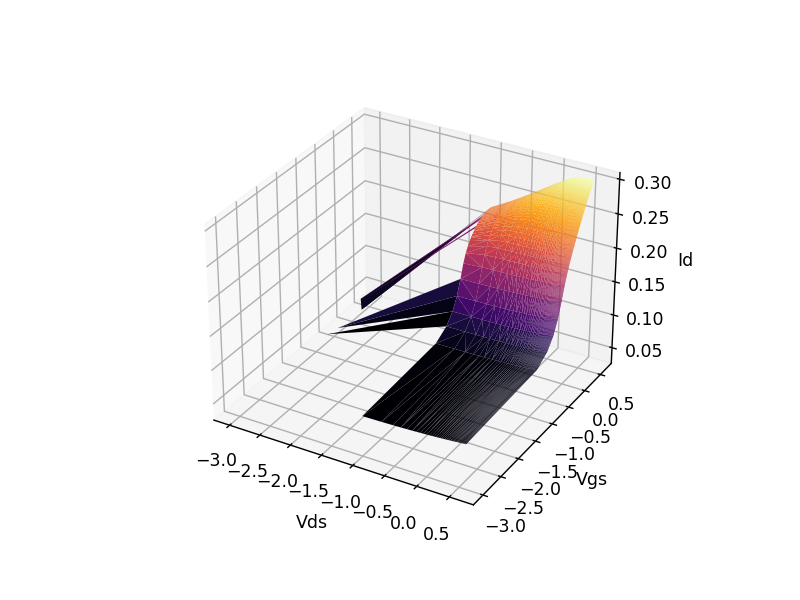

C:\Users\lario\AppData\Local\Temp\ipykernel_4340\747359319.py:18: RuntimeWarning: invalid value encountered in log10
  -1 / np.log10(plot3d['Id'].to_numpy()), cmap='inferno')


In [26]:
plot3d = func_3d(slice(0, 4, .1), np.arange(0, 4, 0.1))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('Vds')
ax.set_ylabel('Vgs')
ax.set_zlabel('Id')

# Replace zeros
plot3d["Id"].replace({0:1e-10}, inplace=True)
plot3d["Vgs"].replace({0:1e-3}, inplace=True)
plot3d["Vds"].replace({0:1e-3}, inplace=True)

# ax.view_init(elev=45, azim=0)

ax.plot_trisurf(np.log10(plot3d['Vds'].to_numpy()), 
                np.log10(plot3d['Vgs'].to_numpy()), 
                -1 / np.log10(plot3d['Id'].to_numpy()), cmap='inferno')

## Датасет для нескольких параметров (Vds, Vgs, Length, Width, Temp)

In [27]:
def mos_circuit(params=None):
#     d = {'vg': 1, 'vd': 2, 'length': 1e-6, 'width':1e-6, 'temp': 25}
    d = {'vg': 1, 'vd': 2, 'length': 5e-7, 'width':5e-7, 'temp': 25}
    if params: 
        for k, v in params.items():
            d[k] = v
            
    circuit = Circuit('MOS circuit')
    circuit.V('G', 'VG', 0, d['vg'])
    circuit.V('D', 'VD', 0, d['vd'])
    circuit.include(spice_library['tsmc018nfet'])
    circuit.M(1, 'VD', 'VG', 0, 0, model='tsmc018nfet', l=d['length'], w=d['width'], )
#     circuit.M(1, 'VD', 'VG', 0, 0, model='ami05nfet')
    
#     circuit.MOSFET(1, 'VD', 'VG', circuit.gnd, circuit.gnd, model='ptm65nm_nmos')
    return circuit

print(mos_circuit())

.title MOS circuit
.include C:\Users\lario\MyAnacondaProject\example\libraries\tsmc018(3).lib
VG VG 0 1
VD VD 0 2
M1 VD VG 0 0 tsmc018nfet l=5e-07 w=5e-07



In [28]:
# def mos_circuit(params=None):
#     d = {'vg': 1, 'vd': 2, 'length': 1e-6, 'width':10e-6, 'temp': 25}
#     if params: 
#         for k, v in params.items():
#             d[k] = v
            
#     circuit = Circuit('MOS circuit')
#     circuit.model('NMOS-SH', 'nmos', Kp=190e-6, Vto=0.57, Lambda=0.16, Gamma=0.50, Phi=0.7)
#     circuit.V('G', 'VG', 0, d['vg'])
#     circuit.V('D', 'VD', 0, d['vd'])
#     circuit.M(1, 'VD', 'VG', 0, 0, model='NMOS-SH', l=d['length'], w=d['width'], temp=d['temp'])


# #     circuit.include(spice_library['ptm32nm_nmos'])
# #     circuit.M(1, 'VD', 'VG', 0, 0, model='ptm32nm_nmos', l=d['length'], w=d['width'])
# #     circuit.MOSFET(1, 'VD', 'VG', circuit.gnd, circuit.gnd, model='ptm65nm_nmos')
#     return circuit

# print(mos_circuit())

In [29]:
def _join_cross(vg_range, l_range, w_range, temp_range):
    ans = []
    for vg in vg_range:
        for l in l_range:
            for w in w_range:
                for t in temp_range:
                    ans.append((vg, l, w, t))
    return np.array(ans)

_join_cross([1, 2], [3, 4], [5, 6], [7, 8])[:5]

array([[1, 3, 5, 7],
       [1, 3, 5, 8],
       [1, 3, 6, 7],
       [1, 3, 6, 8],
       [1, 4, 5, 7]])

In [30]:
def dataset(vd_slice, params_range):
    dataset = {'Vds': [], 'Vgs': [], 'L': [], 'W': [], 'T': [], 'Id': []}
    Vds = np.array([])
    Vgs = np.array([])
    L   = np.array([])
    W   = np.array([])
    T   = np.array([])
    Id  = np.array([])
    
    for vg, l, w, temp in tqdm(params_range):
        circuit = mos_circuit({'vg':vg, 'length': l, 'width': w, 'temp': temp})
        simulator = circuit.simulator(temperature=temp, normal_temperature=25)
        analysis = simulator.dc(VD=vd_slice)
        
        id_range = (- np.array(analysis.branches['vd']))
        len_id = len(id_range)
        
        vd_range = np.arange(vd_slice.start, vd_slice.stop + vd_slice.step, vd_slice.step)
        
        Vds = np.hstack((Vds, vd_range))
        Vgs = np.hstack((Vgs, [vg] * len_id))
        L   = np.hstack((L, [l] * len_id))
        W   = np.hstack((W, [w] * len_id))
        T   = np.hstack((T, [temp] * len_id))
        Id  = np.hstack((Id, id_range))

    dataset['Vds'] = Vds.tolist()
    dataset['Vgs'] = Vgs.tolist()
    dataset['L'] = L.tolist()
    dataset['W'] = W.tolist()
    dataset['T'] = T.tolist()
    dataset['Id'] = Id.tolist()
        
    dataset = pd.DataFrame(dataset, index=None)
    return dataset

In [31]:
np.arange(0, 45, 20)

array([ 0, 20, 40])

len(W) + len(L) = 16 (шт) -- Всего транзисторов

In [37]:
params_range = _join_cross(vg_range=np.arange(0, 3.1, .2),
                           l_range=np.arange(2, 9, 3) * 1e-7, 
                           w_range=np.arange(2, 9, 3) * 1e-7, 
                           temp_range=np.arange(0, 60, 25),
                          )
data = dataset(slice(0, 3, .2), params_range)
data

100%|███████████████████████████████████████████████████████████████████████████████| 432/432 [00:01<00:00, 343.85it/s]


,Vds,Vgs,L,W,T,Id
0,0.0,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.2,0.0,2.000000e-07,2.000000e-07,0.0,1.561556e-12
2,0.4,0.0,2.000000e-07,2.000000e-07,0.0,1.030245e-12
3,0.6,0.0,2.000000e-07,2.000000e-07,0.0,1.475833e-12
4,0.8,0.0,2.000000e-07,2.000000e-07,0.0,1.927819e-12
...,...,...,...,...,...,...
6907,2.2,3.0,8.000000e-07,8.000000e-07,50.0,3.908260e-04
6908,2.4,3.0,8.000000e-07,8.000000e-07,50.0,3.929274e-04
6909,2.6,3.0,8.000000e-07,8.000000e-07,50.0,3.944203e-04
6910,2.8,3.0,8.000000e-07,8.000000e-07,50.0,3.956163e-04


In [38]:
data.shape

(6912, 6)

Сохраним и загрузим датасет

In [39]:
file_name = 'mosfet.csv'
data.to_csv(file_name, index=None)

In [40]:
df = pd.read_csv('mosfet.csv')
df

,Vds,Vgs,L,W,T,Id
0,0.0,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.2,0.0,2.000000e-07,2.000000e-07,0.0,1.561556e-12
2,0.4,0.0,2.000000e-07,2.000000e-07,0.0,1.030245e-12
3,0.6,0.0,2.000000e-07,2.000000e-07,0.0,1.475833e-12
4,0.8,0.0,2.000000e-07,2.000000e-07,0.0,1.927819e-12
...,...,...,...,...,...,...
6907,2.2,3.0,8.000000e-07,8.000000e-07,50.0,3.908260e-04
6908,2.4,3.0,8.000000e-07,8.000000e-07,50.0,3.929274e-04
6909,2.6,3.0,8.000000e-07,8.000000e-07,50.0,3.944203e-04
6910,2.8,3.0,8.000000e-07,8.000000e-07,50.0,3.956163e-04


In [41]:
df['Vgs'].unique()

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. ])

In [42]:
df['L'].unique()

array([2.e-07, 5.e-07, 8.e-07])

In [43]:
df['W'].unique()

array([2.e-07, 5.e-07, 8.e-07])

In [44]:
df['T'].unique()

array([ 0., 25., 50.])

<IPython.core.display.Javascript object>


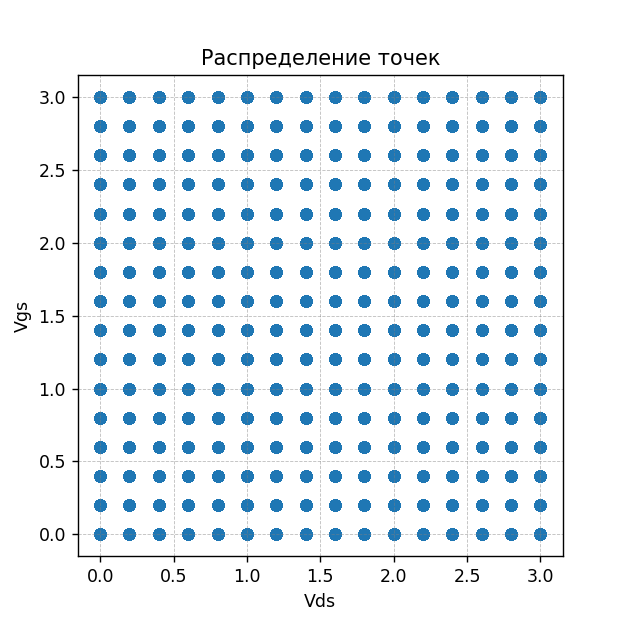

In [45]:
x = df['Vds']
y = df['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


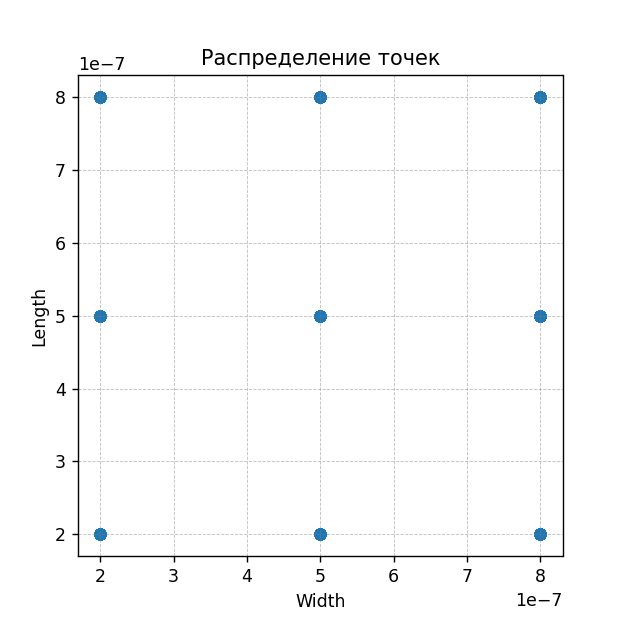

In [46]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.show()

In [47]:
df.iloc[1]['L']

2e-07

<IPython.core.display.Javascript object>


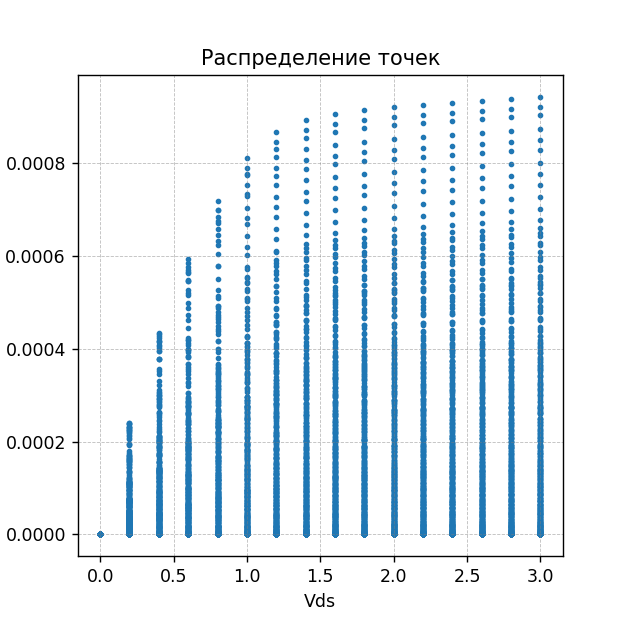

In [48]:
x = df['Vds']
y = df['Id']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Id', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y, s=5)
plt.show()

<IPython.core.display.Javascript object>


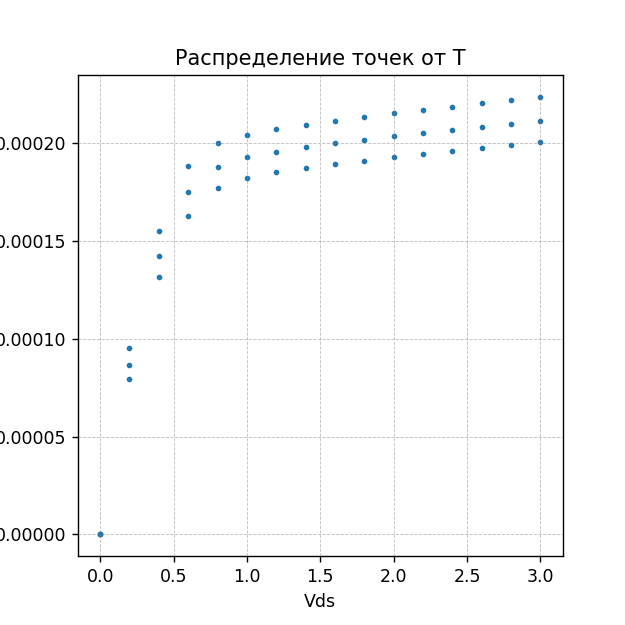

In [49]:
x = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 2.)]['Vds']
y = df[(df['L'] == df.iloc[10]['L']) & (df['W'] == df.iloc[10]['W']) & (df['Vgs'] == 2.)]['Id']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек от T')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y, s=5)
plt.show()

### Данные для валидации

Данные внутри области обучения

In [50]:
np.arange(2.5, 12, 3)

array([ 2.5,  5.5,  8.5, 11.5])

In [52]:
np.arange(2, 9, .5)

array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. ,
       8.5])

In [53]:
params_range_val = _join_cross(vg_range=np.arange(0, 3.1, .1),
                           l_range=np.arange(2, 9, 1) * 1e-7, 
                           w_range=np.arange(2, 9, 1) * 1e-7, 
                           temp_range=np.arange(0, 50, 5),
                          )
data_val = dataset(slice(0, 3, .1), params_range_val)
data_val

100%|███████████████████████████████████████████████████████████████████████████| 15190/15190 [02:12<00:00, 114.99it/s]


,Vds,Vgs,L,W,T,Id
0,0.0,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.1,0.0,2.000000e-07,2.000000e-07,0.0,7.807782e-13
2,0.2,0.0,2.000000e-07,2.000000e-07,0.0,5.893827e-13
3,0.3,0.0,2.000000e-07,2.000000e-07,0.0,8.094150e-13
4,0.4,0.0,2.000000e-07,2.000000e-07,0.0,1.030245e-12
...,...,...,...,...,...,...
470885,2.6,3.0,8.000000e-07,8.000000e-07,45.0,3.950898e-04
470886,2.7,3.0,8.000000e-07,8.000000e-07,45.0,3.957188e-04
470887,2.8,3.0,8.000000e-07,8.000000e-07,45.0,3.962948e-04
470888,2.9,3.0,8.000000e-07,8.000000e-07,45.0,3.968306e-04


In [54]:
file_name = 'mosfet_val_0.csv'
data_val.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


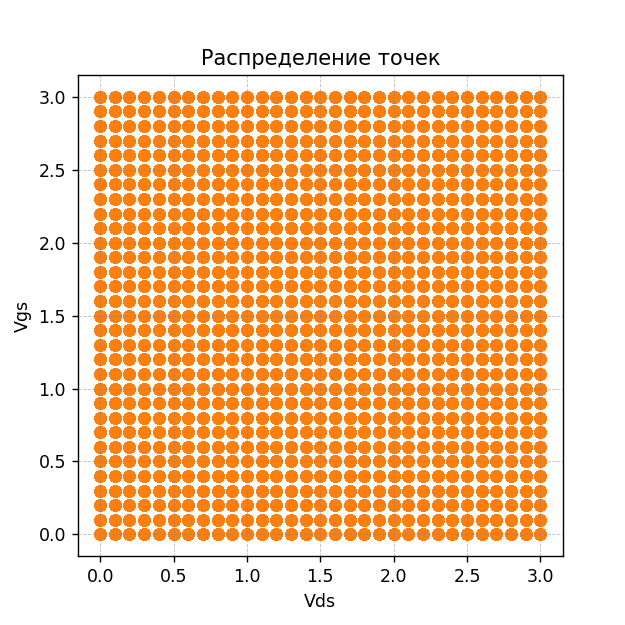

In [55]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

<IPython.core.display.Javascript object>


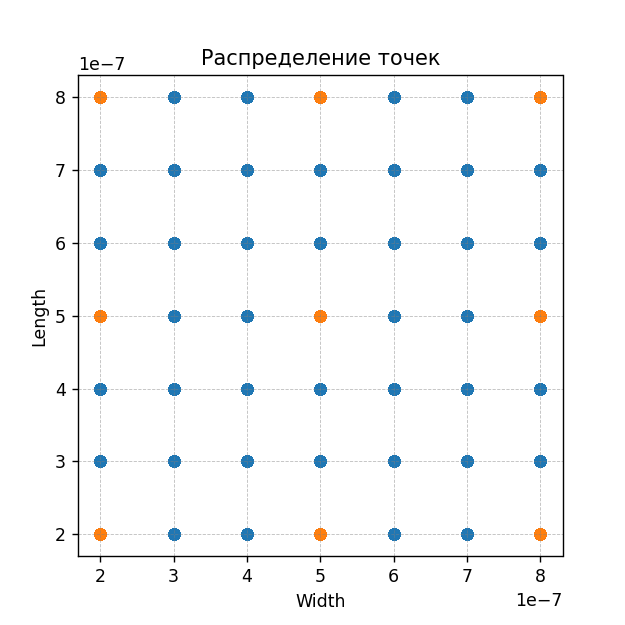

In [56]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
# plt.scatter(x_val, y_val)
plt.show()

Валидационные данные вне области обучения

In [61]:
params_range_val = _join_cross(vg_range=np.arange(0, 6, .1),
                           l_range=np.arange(2, 18, 3) * 1e-7, 
                           w_range=np.arange(2, 18, 3) * 1e-7, 
                           temp_range=np.arange(0, 25, 101),
                          )
data_val = dataset(slice(0, 6, .1), params_range_val)
data_val

100%|█████████████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.70it/s]


,Vds,Vgs,L,W,T,Id
0,0.0,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.1,0.0,2.000000e-07,2.000000e-07,0.0,7.807782e-13
2,0.2,0.0,2.000000e-07,2.000000e-07,0.0,5.893827e-13
3,0.3,0.0,2.000000e-07,2.000000e-07,0.0,8.094150e-13
4,0.4,0.0,2.000000e-07,2.000000e-07,0.0,1.030245e-12
...,...,...,...,...,...,...
131755,5.6,5.9,1.700000e-06,1.700000e-06,0.0,1.093667e-03
131756,5.7,5.9,1.700000e-06,1.700000e-06,0.0,1.105809e-03
131757,5.8,5.9,1.700000e-06,1.700000e-06,0.0,1.117707e-03
131758,5.9,5.9,1.700000e-06,1.700000e-06,0.0,1.129364e-03


In [62]:
file_name = 'mosfet_val_1.csv'
data_val.to_csv(file_name, index=None)

<IPython.core.display.Javascript object>


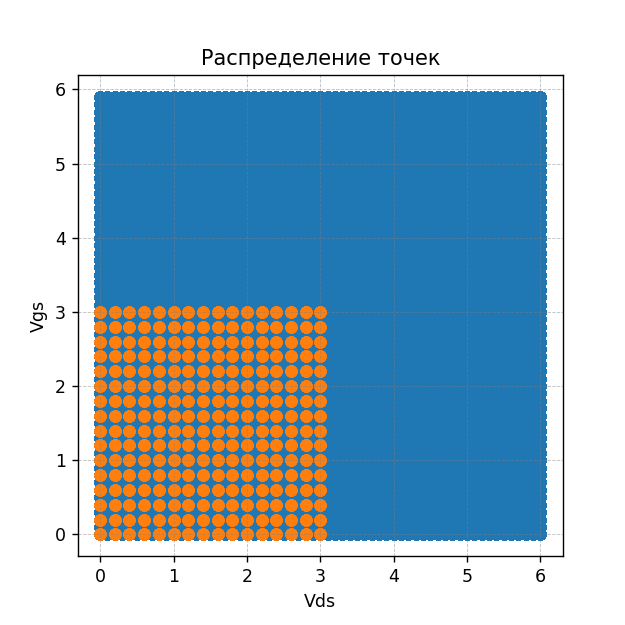

In [65]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vds']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

<IPython.core.display.Javascript object>


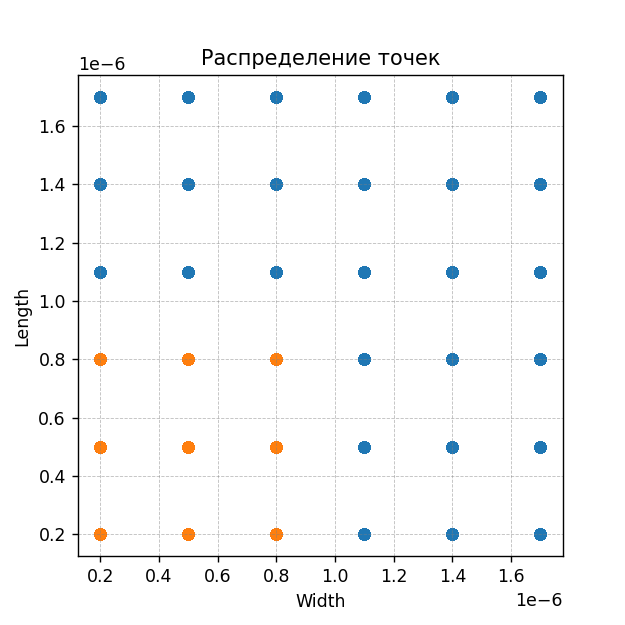

In [66]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['W']
y_val = data_val[data_val['T'] == data_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

Данные для графиков

In [70]:
data_val = dataset(slice(0, 6, .1), [(0.1, 2 * 1e-7, 2 * 1e-7, 25)])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


In [71]:
file_name = 'mosfet_val_3.csv'
data_val.to_csv(file_name, index=None)

In [74]:
data_val = dataset(slice(0, 6, .1), [(0.5, 2 * 1e-7, 2 * 1e-7, 25)])
file_name = 'mosfet_val_4.csv'
data_val.to_csv(file_name, index=None)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [78]:
data_val = dataset(slice(0, 6, .1), [(2, 5 * 1e-7, 5 * 1e-7, 25)])
file_name = 'mosfet_val_5.csv'
data_val.to_csv(file_name, index=None)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [80]:
data_val = dataset(slice(0, 6, .1), [(5, 5 * 1e-7, 5 * 1e-7, 25)])
file_name = 'mosfet_val_6.csv'
data_val.to_csv(file_name, index=None)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [81]:
data_val = dataset(slice(0, 8, .1), [(2, 15 * 1e-7, 15 * 1e-7, 65)])
file_name = 'mosfet_val_7.csv'
data_val.to_csv(file_name, index=None)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.88it/s]
